# **Demand Forecasting Analysis**

## Introduction
### Dataset Overview
- A store chain's 5-year data includes information on 10 different stores and 50 different products.
- The data set covers the period between 01-01-2013 and 31-12-2017.

### Problem
- It is desired to create a 3-month demand forecasting model for 10 different stores and 50 different products of a chain of stores.
- Afterwards, it is desired to reduce the data set to weekly and create a demand forecasting model for 2017.

### Variables
- date: Date of sales data (No holiday effects or store closures)
- store: Store ID Unique number for each store.
- item: Item ID Unique number for each item.
- sales: Number of items sold, Number of items sold from a particular store on a given date

## 1. Importing Libraries
Import essential libraries and tools required for data analysis, visualization, and demand forecastings, such as pandas, matplotlib, and seaborn, and forecasting-specific tools such as Random Forest Regressor. This ensures all necessary tools are available for analysis and modeling.

In [20]:
# Setup Libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.filterwarnings('ignore')

## 2. Load Dataset

Load and merge the training and testing data to prepare it for analysis.

In [41]:
train = pd.read_csv('demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
test = pd.read_csv('demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False)
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [22]:
print("Size of the train set:",train.shape)
print("Size of the test set:",test.shape)

#Removing the extra column 'id'
df.drop(['id'],inplace=True,axis=1)
df.columns

Size of the train set: (913000, 4)
Size of the test set: (45000, 4)


Index(['date', 'store', 'item', 'sales'], dtype='object')

## 3. Basic Exploratory Data Analysis

Likely to gain initial insights into data distribution, patterns, or missing values.
1. Collecting Statistics of Variables: Summary statistics (like mean, min, max, etc.) provide insights into the overall distribution of each variable, helping to identify central tendencies and outliers in the data.
2. Sale Statistics in store-product breakdown: calculates various sales statistics (sum, mean, median, and standard deviation) for each unique combination of store and item.
3. Line Plot of Sales Over Time: This shows trends or seasonality in sales across dates.
4. Correlation Heatmap: Visualizes relationships between variables, highlighting correlations.
5. Pairplot of Store, Item, and Sales: Shows scatter plots and distributions to explore variable relationships.

In [23]:
# Cheacking data range
print("Date range:", df["date"].min(), "to", df["date"].max())

Date range: 2013-01-01 00:00:00 to 2018-03-31 00:00:00


In [24]:
# Sales distribution
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
10%          20.000000
30%          33.000000
50%          47.000000
70%          64.000000
80%          76.000000
90%          93.000000
95%         107.000000
99%         135.000000
max         231.000000
Name: sales, dtype: float64

In [25]:
# Number of stores and products
print(f"Number of stores: {df['store'].nunique()}")
print(f"Number of products: {df['item'].nunique()}")

Number of stores: 10
Number of products: 50


In [26]:
# Number of unique products in each store
products_per_store = df.groupby("store")["item"].nunique()
print(products_per_store)

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64


In [27]:
# Calculate sales statistics for each store-product combination
sales_stats = df.groupby(["store", "item"]).agg({
    "sales": ["sum", "mean", "median", "std"]
})

print(sales_stats)

               sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]


### Visualization

In [28]:
# Re-create sample dataset
np.random.seed(0)
dates = pd.date_range(start="2017-01-01", end="2017-12-31", freq="D")
data = {
    'date': dates,
    'store': np.random.choice(range(1, 11), len(dates)),
    'item': np.random.choice(range(1, 51), len(dates)), 
    'sales': np.random.poisson(lam=20, size=len(dates))   
}
df = pd.DataFrame(data)

1. **Line Plot of Sales Over Time:**

    The line plot reveals the sales trend throughout the year, highlighting potential patterns such as seasonality or fluctuations.  This analysis can guide inventory planning and staffing to meet demand during high- and low-sales periods.

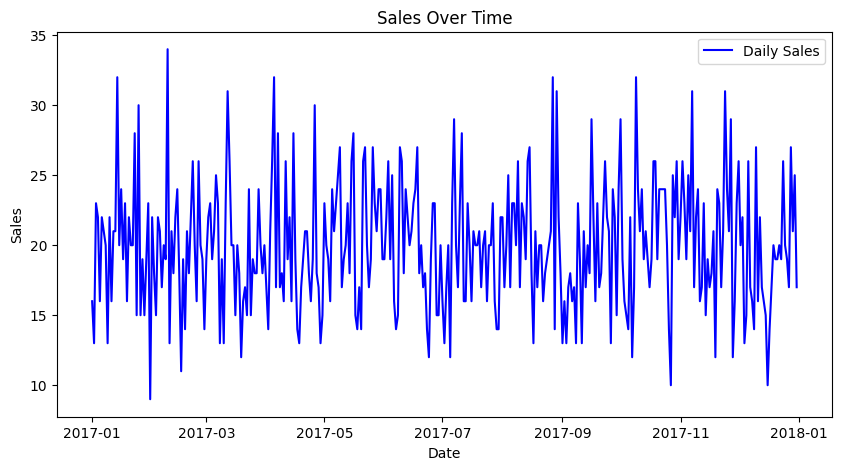

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['sales'], label='Daily Sales', color='blue')
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

2. **Correlation Heatmap:**
    
    The heatmap provides insights into the relationships between the variables store, item, and sales. A strong positive correlation between sales and store could suggest that certain stores consistently outperform others, while a correlation between sales and item indicates that some products drive more sales than others.

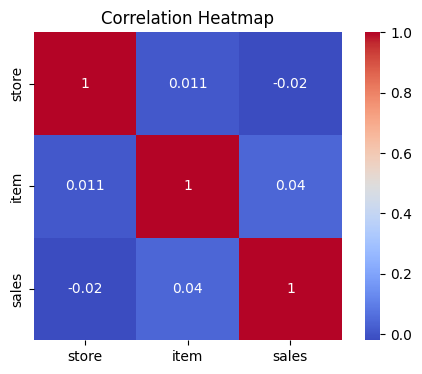

In [30]:
plt.figure(figsize=(6, 4))
correlation = df[['store', 'item', 'sales']].corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()

3. **Pairplot of Store, Item, and Sales:**

    The pairplot shows the distributions and relationships between store, item, and sales. The diagonal plots reveal how each variable is distributed, such as whether sales are skewed due to a few stores or items dominating the total. Scatterplots between store and sales or item and sales may reveal clusters of stores or items with similar sales performance.

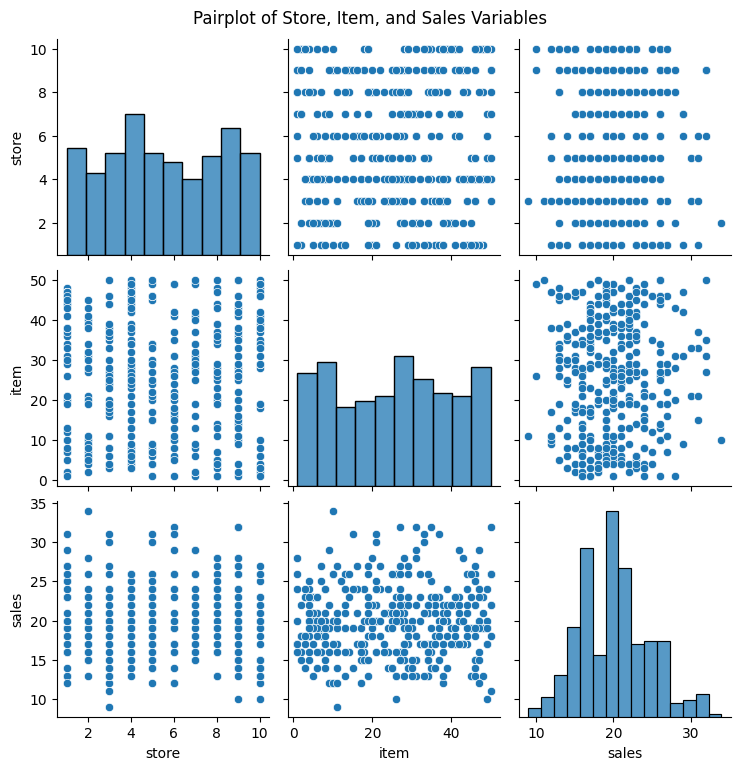

In [31]:
sns.pairplot(df[['store', 'item', 'sales']])
plt.suptitle("Pairplot of Store, Item, and Sales Variables", y=1.02)
plt.show()

## 4. Data Transformation

Develops new features by coding transformations, such as extracting insights from time-based data, aggregating sales metrics, or introducing seasonal indicators to enhance the dataset's predictive power.

In [32]:
# Function to add date and time features to a DataFrame
def add_date_features(df, date_column):
    df['month'] = df[date_column].dt.month
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['week_of_year'] = df[date_column].dt.isocalendar().week
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['year'] = df[date_column].dt.year
    df['is_wknd'] = (df[date_column].dt.weekday >= 5).astype(int)
    df['is_month_start'] = df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    return df


df = add_date_features(df, 'date')
df.head()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2017-01-01,6,24,16,1,1,1,52,6,2017,1,1,0
1,2017-01-02,1,31,13,1,2,2,1,0,2017,0,0,0
2,2017-01-03,4,26,23,1,3,3,1,1,2017,0,0,0
3,2017-01-04,4,21,22,1,4,4,1,2,2017,0,0,0
4,2017-01-05,8,34,16,1,5,5,1,3,2017,0,0,0


In [33]:
# Sales statistics grouped by store, item, and month
sales_stats = df.groupby(["store", "item", "month"]).agg({
    "sales": ["sum", "mean", "median", "std"]
})

print(sales_stats)

                 sales                       
                   sum  mean median       std
store item month                             
1     1    10       17  17.0   17.0       NaN
      2    7        16  16.0   16.0       NaN
      5    1        19  19.0   19.0       NaN
      7    2        19  19.0   19.0       NaN
           6        27  27.0   27.0       NaN
...                ...   ...    ...       ...
10    46   9        13  13.0   13.0       NaN
      47   6        15  15.0   15.0       NaN
      48   2        21  21.0   21.0       NaN
      49   10       29  14.5   14.5  6.363961
      50   9        22  22.0   22.0       NaN

[355 rows x 4 columns]


In [40]:
#Checking the structure of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            365 non-null    datetime64[ns]
 1   store           365 non-null    int64         
 2   item            365 non-null    int64         
 3   sales           365 non-null    int64         
 4   month           365 non-null    int32         
 5   day_of_month    365 non-null    int32         
 6   day_of_year     365 non-null    int32         
 7   week_of_year    365 non-null    UInt32        
 8   day_of_week     365 non-null    int32         
 9   year            365 non-null    int32         
 10  is_wknd         365 non-null    int64         
 11  is_month_start  365 non-null    int64         
 12  is_month_end    365 non-null    int64         
 13  lag_1           365 non-null    float64       
 14  lag_7           365 non-null    float64       
 15  rollin

## 5. Use Random Forest Regressor

In this section, trained a Random Forest Regressor for demand forecasting. Multiple steps for model training and evaluation, likely including parameter selection and result interpretation.

In [43]:
# Step 1: Feature Engineering
df['lag_1'] = df['sales'].shift(1).fillna(0)
df['lag_7'] = df['sales'].shift(7).fillna(0)
df['rolling_mean_7'] = df['sales'].rolling(7).mean().fillna(df['sales'].mean())

# Ensure date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Check the date range in the dataset
print("Date range in dataset:", df['date'].min(), df['date'].max())

# Train-Test Split
train = df[df['date'] < '2017-01-01'] 
test = df[df['date'] >= '2017-01-01']

# Verify split
print(f"Train set shape: {train.shape}, Test set shape: {test.shape}")

# Feature and Target Selection
X_train = train[['lag_1', 'lag_7', 'rolling_mean_7', 'store', 'item']]
y_train = train['sales']
X_test = test[['lag_1', 'lag_7', 'rolling_mean_7', 'store', 'item']]
y_test = test['sales']

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


Date range in dataset: 2013-01-01 00:00:00 2018-03-31 00:00:00
Train set shape: (730500, 8), Test set shape: (227500, 8)
X_train shape: (730500, 5), y_train shape: (730500,)


In [44]:
#Step 2: Train and Predict for the model
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
test_preds = rf_model.predict(X_test)

In [51]:
# Define actual and predicted values
y_true = y_test
y_pred = test_preds

# Ensure there are no NaNs in y_true or y_pred
print(f"NaNs in y_true: {np.isnan(y_true).sum()}")
print(f"NaNs in y_pred: {np.isnan(y_pred).sum()}")

# Or fill NaNs with mean
y_true = np.nan_to_num(y_true, nan=np.nanmean(y_true))

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Root Mean Square Error (RMSE): {rmse}")

NaNs in y_true: 45000
NaNs in y_pred: 0
Mean Absolute Error (MAE): 12.896445808781893
Root Mean Square Error (RMSE): 18.167873398676864


## 6. Prediction - Final Result

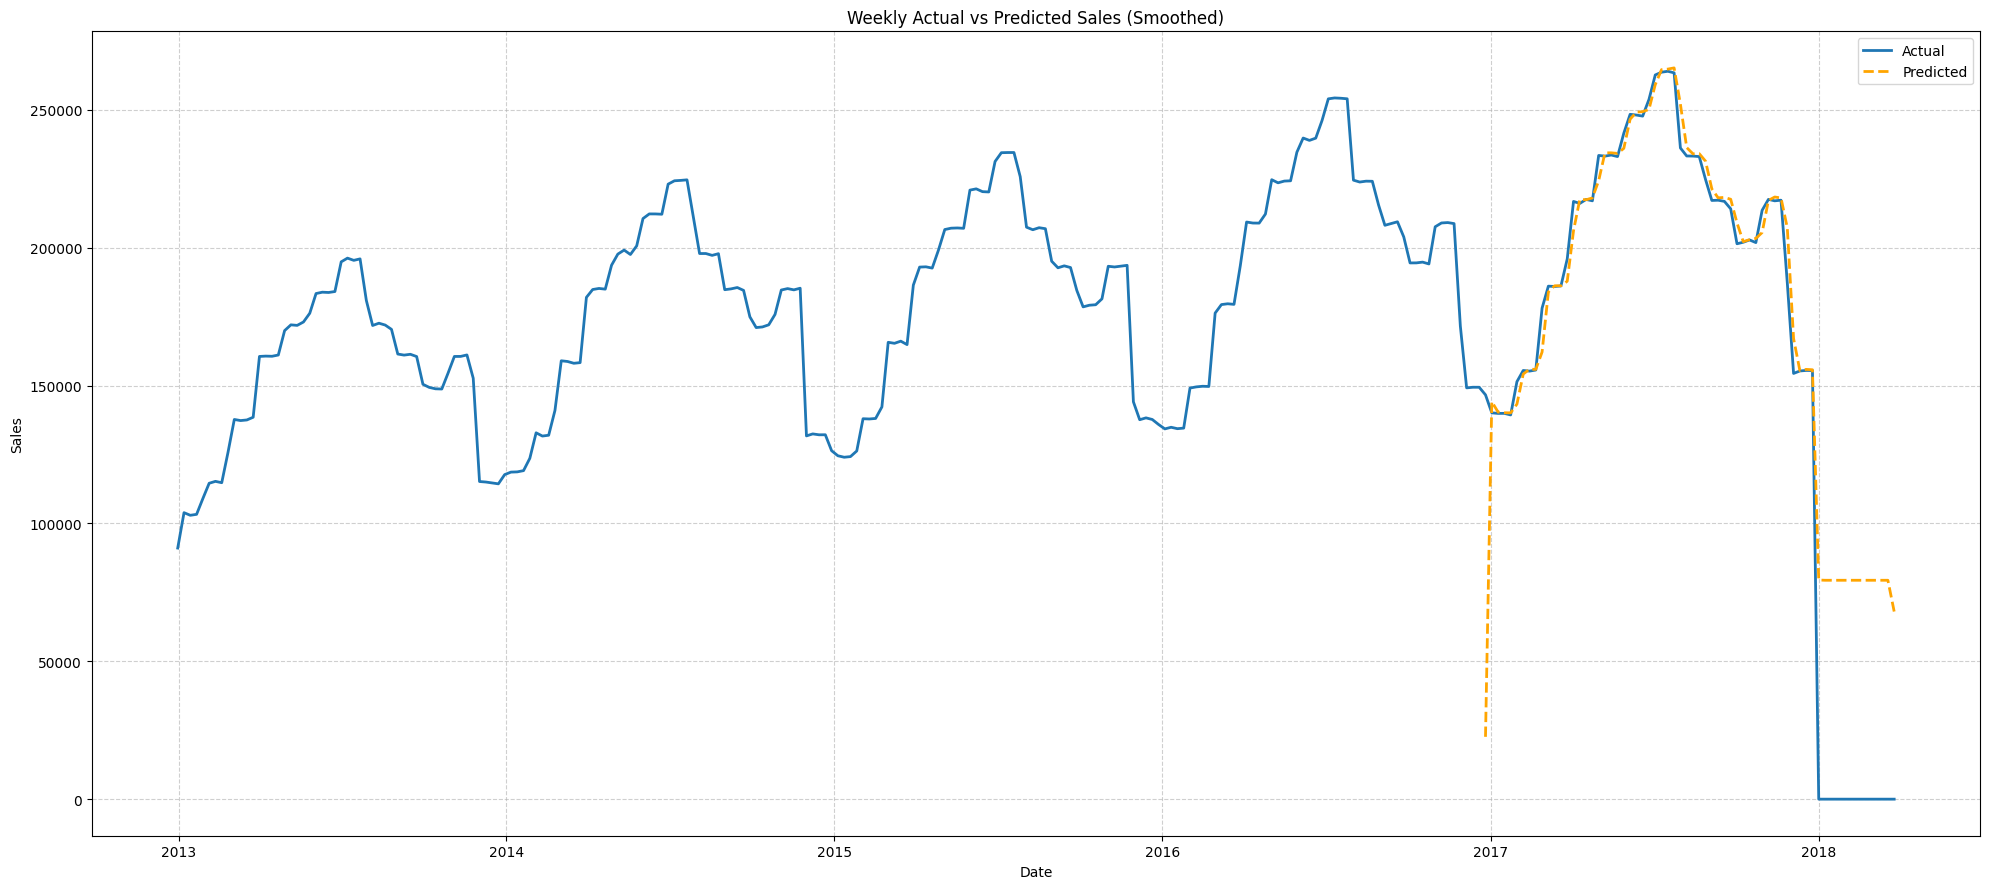

In [ ]:
#Step 3: Visualize actual vs. predicted sales:
# Aggregate data by week
test['predicted_sales'] = test_preds
test['week'] = test['date'].dt.to_period('W').apply(lambda r: r.start_time)
df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# Group by week for both actual and predicted sales
weekly_actual = df.groupby('week')['sales'].sum().reset_index()
weekly_forecast = test.groupby('week')['predicted_sales'].sum().reset_index()

# Apply rolling mean for smoothing
weekly_actual['sales_smooth'] = weekly_actual['sales'].rolling(1).mean() 
weekly_forecast['sales_smooth'] = weekly_forecast['predicted_sales'].rolling(1).mean()

# Visualization
plt.figure(figsize=(20, 9))
plt.plot(weekly_actual['week'], weekly_actual['sales_smooth'], label='Actual', linewidth=2)
plt.plot(weekly_forecast['week'], weekly_forecast['sales_smooth'], label='Predicted', linewidth=2, linestyle='--', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Weekly Actual vs Predicted Sales (Smoothed)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

